# Preparings

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import geometric_sampling as gs
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull

## Population

In [59]:
rng = gs.random.rng()
grid_size = 30
N = grid_size**2
n = 8
# coords = rng.grid_coordinates((grid_size, 2))
# coords = np.column_stack([coords, np.zeros((10,))])
coords = rng.random_coordinates((N, 2))
# coords = rng.cluster_coordinates(4, 0.05, size=(N, 2))
probs = rng.equal_probabilities(n, N)
num_samples = 20

In [59]:
coords = np.array(
    [
        [-3.15, 0.5],
        [-2.45, 0.5],
        [-1.75, 0.5],
        [-1.05, 0.5],
        [-0.35, 0.5],
        [0.35, 0.5],
        [1.05, 0.5],
        [1.75, 0.5],
        [2.45, 0.5],
        [3.15, 0.5],
    ]
)

In [38]:
coords = coords[:, [0]]
coords

array([[-3.15],
       [-2.45],
       [-1.75],
       [-1.05],
       [-0.35],
       [ 0.35],
       [ 1.05],
       [ 1.75],
       [ 2.45],
       [ 3.15]])

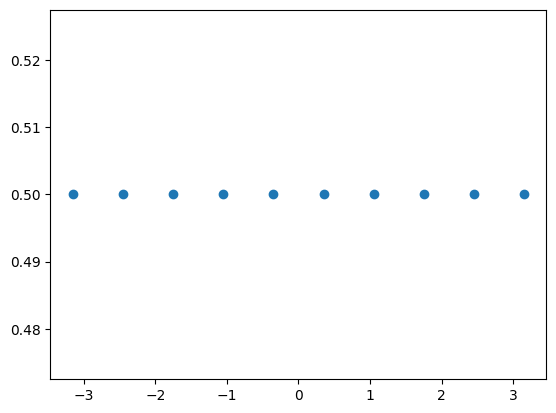

In [17]:
plt.scatter(*coords.T)

## Samples

### Random and Method

In [60]:
kss = gs.sampling.KMeansSpatialSampling(coords, probs, n=n, n_zones=(2, 2), tolerance=5)
method_samples = kss.sample(num_samples)

In [61]:
ran = gs.sampling.RandomSampling(coords, probs, n=n)
random_samples = ran.sample(num_samples)

### Hand-pick

In [49]:
def two_d_index_to_flat_index(index):
    return (index[0] - 1) + (index[1] - 1) * grid_size


def generate_initial_points(mode):
    if mode == "center":
        first_point = np.array([grid_size // 2, grid_size // 2])
        return [
            first_point,
            first_point + np.array([0, 1]),
            first_point + np.array([1, 0]),
            first_point + np.array([1, 1]),
        ]
    if mode == "centroid":
        first_point = np.array(
            [int(np.ceil(grid_size / 4)), int(np.ceil(grid_size / 4))]
        )
        return [
            first_point,
            first_point + np.array([0, grid_size // 2]),
            first_point + np.array([grid_size // 2, 0]),
            first_point + np.array([grid_size // 2, grid_size // 2]),
        ]


def generate_samples(initial, step_directions, n_samples):
    samples = [[two_d_index_to_flat_index(point) for point in initial]]
    for i in range(1, n_samples):
        sample = []
        for point, step_direction in zip(initial, step_directions):
            new_point = np.array(point) + np.array(step_direction) * i
            new_point_flat = two_d_index_to_flat_index(new_point)
            if (
                new_point[0] < 1
                or new_point[0] > grid_size
                or new_point[1] < 1
                or new_point[1] > grid_size
                or new_point_flat < 0
                or new_point_flat >= N
            ):
                return np.array(samples)
            sample.append(new_point_flat)
        samples.append(sample)
    return np.array(samples)


def find_closest_index(point, grid):
    distances = np.linalg.norm(grid - point, axis=1)
    return np.argmin(distances)


def generate_closest_index_based_samples(n_samples):
    d = 0.01
    initial = [
        [0.5 - d, 0.5 - d],
        [0.5 - d, 0.5 + d],
        [0.5 + d, 0.5 - d],
        [0.5 + d, 0.5 + d],
    ]
    samples = [[find_closest_index(np.array(point), coords) for point in initial]]
    d = 0.05
    step_directions = np.array([[-d, -d], [-d, d], [d, -d], [d, d]])
    for i in range(1, n_samples):
        sample = []
        for point, step_direction in zip(initial, step_directions):
            new_point = np.array(point) + step_direction * i
            new_point_flat = find_closest_index(new_point, coords)
            if (
                new_point[0] > 1
                or new_point[0] < 0
                or new_point[1] > 1
                or new_point[1] < 0
            ):
                return np.array(samples)
            sample.append(new_point_flat)
        samples.append(sample)
    return np.array(samples)


def generate_closest_index_based_samples2(n_samples, n_clusters):
    angles = np.linspace(0, 2 * np.pi, n_clusters, endpoint=False)
    radius = 0.05
    step_directions = np.column_stack((np.cos(angles), np.sin(angles))) * radius

    initial = [[0.5, 0.5] + step for step in step_directions]
    samples = [[find_closest_index(np.array(point), coords) for point in initial]]

    for i in range(1, n_samples):
        sample = []
        for point, step_direction in zip(initial, step_directions):
            new_point = np.array(point) + step_direction * i
            new_point_flat = find_closest_index(new_point, coords)
            if np.any(new_point < 0) or np.any(new_point > 1):
                return np.array(samples)
            sample.append(new_point_flat)
        samples.append(sample)

    return np.array(samples)

In [62]:
initials = generate_initial_points("center")
handpick_samples = generate_samples(
    initials, [(-1, -1), (-1, 1), (1, -1), (1, 1)], num_samples
)
handpick_closest_samples = generate_closest_index_based_samples2(num_samples, n)

In [41]:
handpick_closest_samples.shape

(10, 4)

In [76]:
handpick_closest_samples = np.array([[0, 9], [1, 8], [2, 7], [3, 6], [4, 5]])

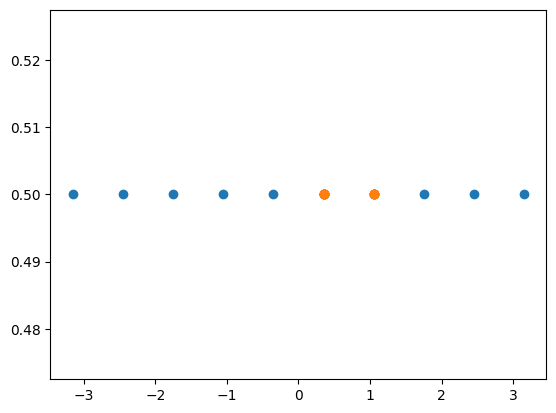

In [9]:
plt.scatter(*coords.T)
plt.scatter(*coords[handpick_closest_samples].T)

# Plots

In [25]:
def assign_samples_to_clusters(samples, centroids):
    cost_matrix = np.linalg.norm(
        samples[:, :, np.newaxis] - centroids, axis=3
    ).transpose(0, 2, 1)
    return np.array(
        [
            samples[i][linear_sum_assignment(cost_matrix[i])[1]]
            for i in range(samples.shape[0])
        ]
    )


def plot_samples(
    coords,
    samples,
    centroids,
    labels,
    measures=None,
    plot_centroids=True,
    plot_lines=True,
):
    fig, axes = plt.subplots(4, 4, figsize=(14, 14))
    axes = axes.flatten()

    assigned_samples = assign_samples_to_clusters(samples, centroids)

    for i, sample in enumerate(assigned_samples):
        ax = axes[i]
        ax.scatter(coords[:, 0], coords[:, 1], c=labels, alpha=0.7)
        ax.scatter(sample[:, 0], sample[:, 1], c="red", marker="*", s=200)

        if plot_centroids:
            ax.scatter(centroids[:, 0], centroids[:, 1], c="black", marker="X", s=100)

        if plot_lines:
            for j in range(assigned_samples.shape[1]):
                ax.plot(
                    [sample[j, 0], centroids[j, 0]],
                    [sample[j, 1], centroids[j, 1]],
                    c="black",
                    linestyle="--",
                )

        if measures:
            ax.set_title(", ".join(str(round(measure[i], 2)) for measure in measures))

        ax.grid(alpha=0.5)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    for ax in axes[assigned_samples.shape[0] :]:
        fig.delaxes(ax)

    plt.subplots_adjust(hspace=0.3)


def plot_densities(densities, measures=None, color="red"):
    fig, axes = plt.subplots(4, 4, figsize=(14, 14))
    axes = axes.flatten()
    for i, density in enumerate(densities):
        ax = axes[i]
        ax.scatter(density[0], density[1], c=color, alpha=0.7)
        ax.plot([0, 1], [0, 1], c="black")

        if measures:
            ax.set_title(", ".join(str(round(measure[i], 2)) for measure in measures))

        ax.grid(alpha=0.5)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    for ax in axes[len(densities) :]:
        fig.delaxes(ax)

    plt.subplots_adjust(hspace=0.3)


def plot_convex_hull(points, ax, color, alpha=0.3, edge_color="black", line_width=1.0):
    if len(points) < 3:
        return ax, None
    hull = ConvexHull(points)
    polygon = Polygon(
        points[hull.vertices],
        closed=True,
        facecolor=color,
        alpha=alpha,
        edgecolor=edge_color,
        lw=line_width,
    )
    ax.add_patch(polygon)
    return ax, hull


def grand_plot(clusters, centroids, samples, densities, measures=None):
    num_rows = samples.shape[0]
    fig, axes = plt.subplots(num_rows, 3, figsize=(12, 3.5 * num_rows))

    assigned_samples = assign_samples_to_clusters(coords[samples], centroids)

    for i in range(num_rows):
        ax = axes[i, 0]

        for cluster_idx, cluster in enumerate(clusters):
            cluster_points = cluster[:, 1:3]
            cluster_color = plt.cm.tab10(cluster_idx % 10)
            ax, _ = plot_convex_hull(cluster_points, ax, color=cluster_color, alpha=0.2)
            ax.scatter(
                cluster_points[:, 0],
                cluster_points[:, 1],
                color=cluster_color,
                s=cluster[:, 3] * 1000,
                alpha=0.8,
            )

        ax.scatter(
            centroids[:, 0], centroids[:, 1], c="black", marker="X", s=100, alpha=0.5
        )
        ax.scatter(
            assigned_samples[i, :, 0],
            assigned_samples[i, :, 1],
            c="black",
            marker="*",
            s=200,
        )

        for j in range(samples.shape[1]):
            ax.plot(
                [assigned_samples[i, j, 0], centroids[j, 0]],
                [assigned_samples[i, j, 1], centroids[j, 1]],
                c="black",
                linestyle="--",
            )

        if measures:
            ax.set_title(", ".join(str(round(measure[i], 2)) for measure in measures))

        ax.grid(alpha=0.5)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        ax = axes[i, 1]
        ax.scatter(densities[i][0], densities[i][1], c="red", alpha=0.6)
        maximum = max(np.max(densities[i][0]), np.max(densities[i][1]), 0.9)
        ax.plot([0, maximum + 0.1], [0, maximum + 0.1], c="black")

        ax.grid(alpha=0.5)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        ax = axes[i, 2]
        data = densities[i][1] - densities[i][0]
        bin_width = 0.1
        bins = np.arange(min(data), max(data) + bin_width, bin_width)

        ax.hist(data, bins=bins, edgecolor="black", alpha=0.6, color="blue")
        ax.grid(alpha=0.5)
        ax.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

    plt.subplots_adjust(hspace=0.3)


def grand_plot2(clusters, centroids, samples, densities, measures=None):
    num_samples = samples.shape[0]
    num_rows = num_samples // 2  # Each row contains two samples (4 plots total)
    fig, axes = plt.subplots(num_rows, 4, figsize=(16, 3.5 * num_rows))

    assigned_samples = assign_samples_to_clusters(coords[samples], centroids)

    for i in range(num_rows):
        for j in range(2):  # Two samples per row
            sample_idx = 2 * i + j  # Compute the sample index
            if sample_idx >= num_samples:
                break

            ax = axes[i, 2 * j]  # First plot (Convex Hull)
            for cluster_idx, cluster in enumerate(clusters):
                cluster_points = cluster[:, 1:3]
                cluster_color = plt.cm.tab10(cluster_idx % 10)
                ax, _ = plot_convex_hull(
                    cluster_points, ax, color=cluster_color, alpha=0.2
                )
                ax.scatter(
                    cluster_points[:, 0],
                    cluster_points[:, 1],
                    color=cluster_color,
                    s=cluster[:, 3] * 1000,
                    alpha=0.8,
                )

            ax.scatter(
                centroids[:, 0],
                centroids[:, 1],
                c="black",
                marker="X",
                s=100,
                alpha=0.5,
            )
            ax.scatter(
                assigned_samples[sample_idx, :, 0],
                assigned_samples[sample_idx, :, 1],
                c="black",
                marker="*",
                s=200,
            )

            for k in range(samples.shape[1]):
                ax.plot(
                    [assigned_samples[sample_idx, k, 0], centroids[k, 0]],
                    [assigned_samples[sample_idx, k, 1], centroids[k, 1]],
                    c="black",
                    linestyle="--",
                )

            if measures:
                ax.set_title(
                    ", ".join(
                        str(round(measure[sample_idx], 2)) for measure in measures
                    )
                )

            ax.grid(alpha=0.5)
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

            ax = axes[i, 2 * j + 1]  # Second plot (Density Scatter)
            ax.scatter(
                densities[sample_idx][0], densities[sample_idx][1], c="red", alpha=0.6
            )
            maximum = max(
                np.max(densities[sample_idx][0]), np.max(densities[sample_idx][1]), 0.9
            )
            ax.plot([0, maximum + 0.1], [0, maximum + 0.1], c="black")

            ax.grid(alpha=0.5)
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.subplots_adjust(hspace=0.3)

# Main

In [63]:
density_measure = gs.measure.Density(coords, probs, n)
clusters, centroids = density_measure.clusters, density_measure.centroids

In [76]:
method_scores, method_densities = density_measure.score(method_samples)

random_scores, random_densities = density_measure.score(random_samples)

handpick_scores, handpick_densities = density_measure.score(handpick_closest_samples)

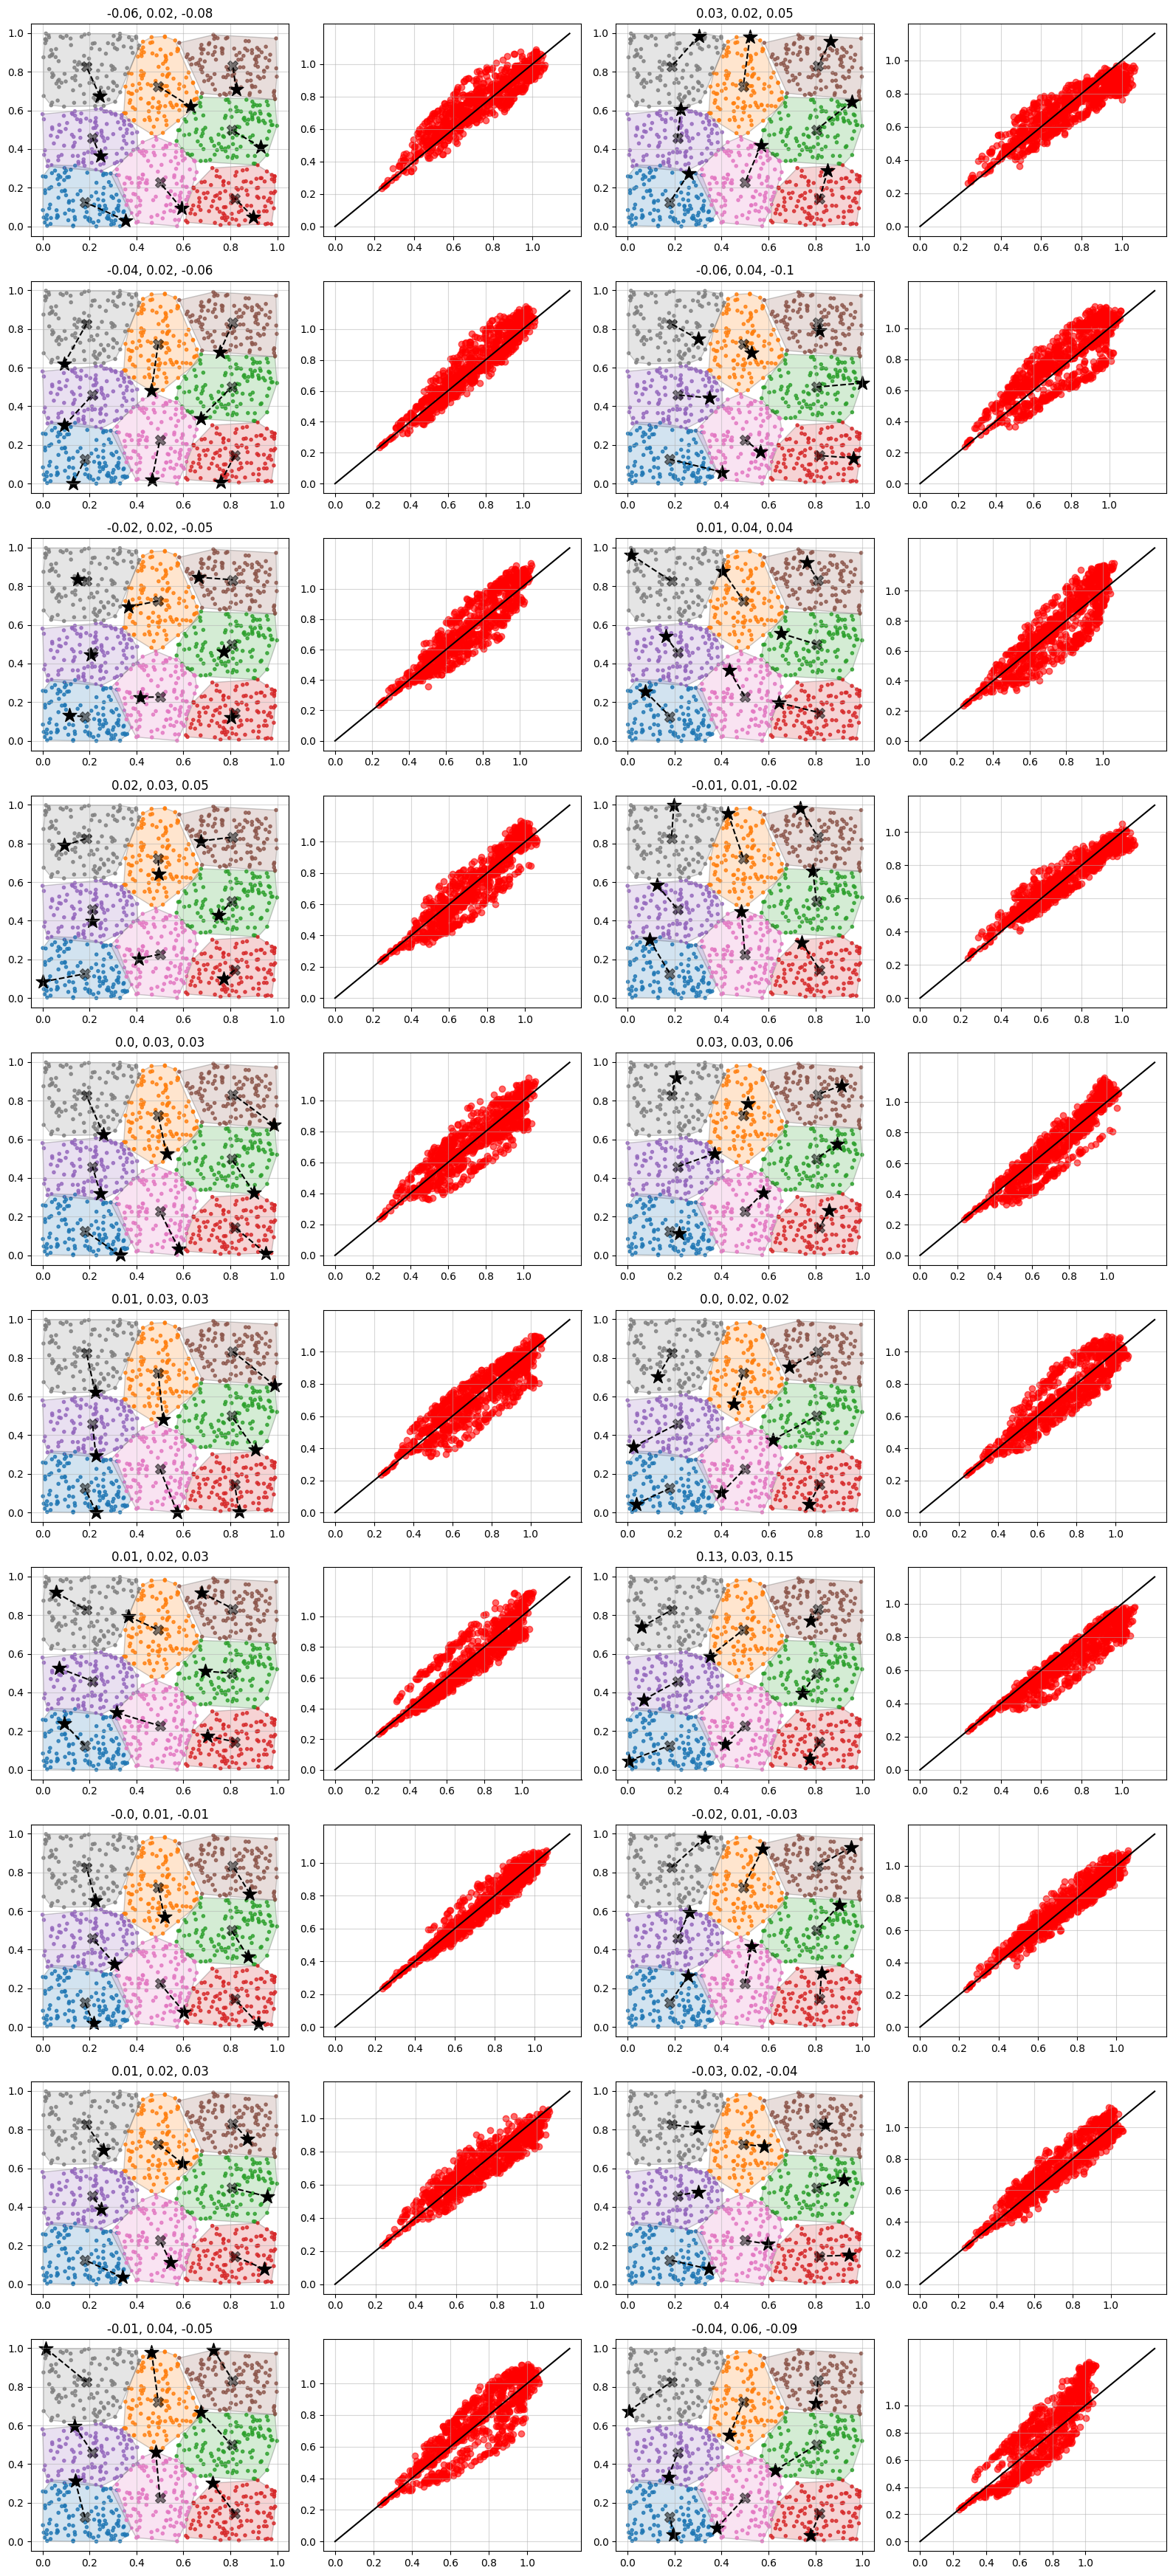

In [77]:
grand_plot2(clusters, centroids, method_samples, method_densities, method_scores)
plt.tight_layout()
plt.savefig("method.png", dpi=150)

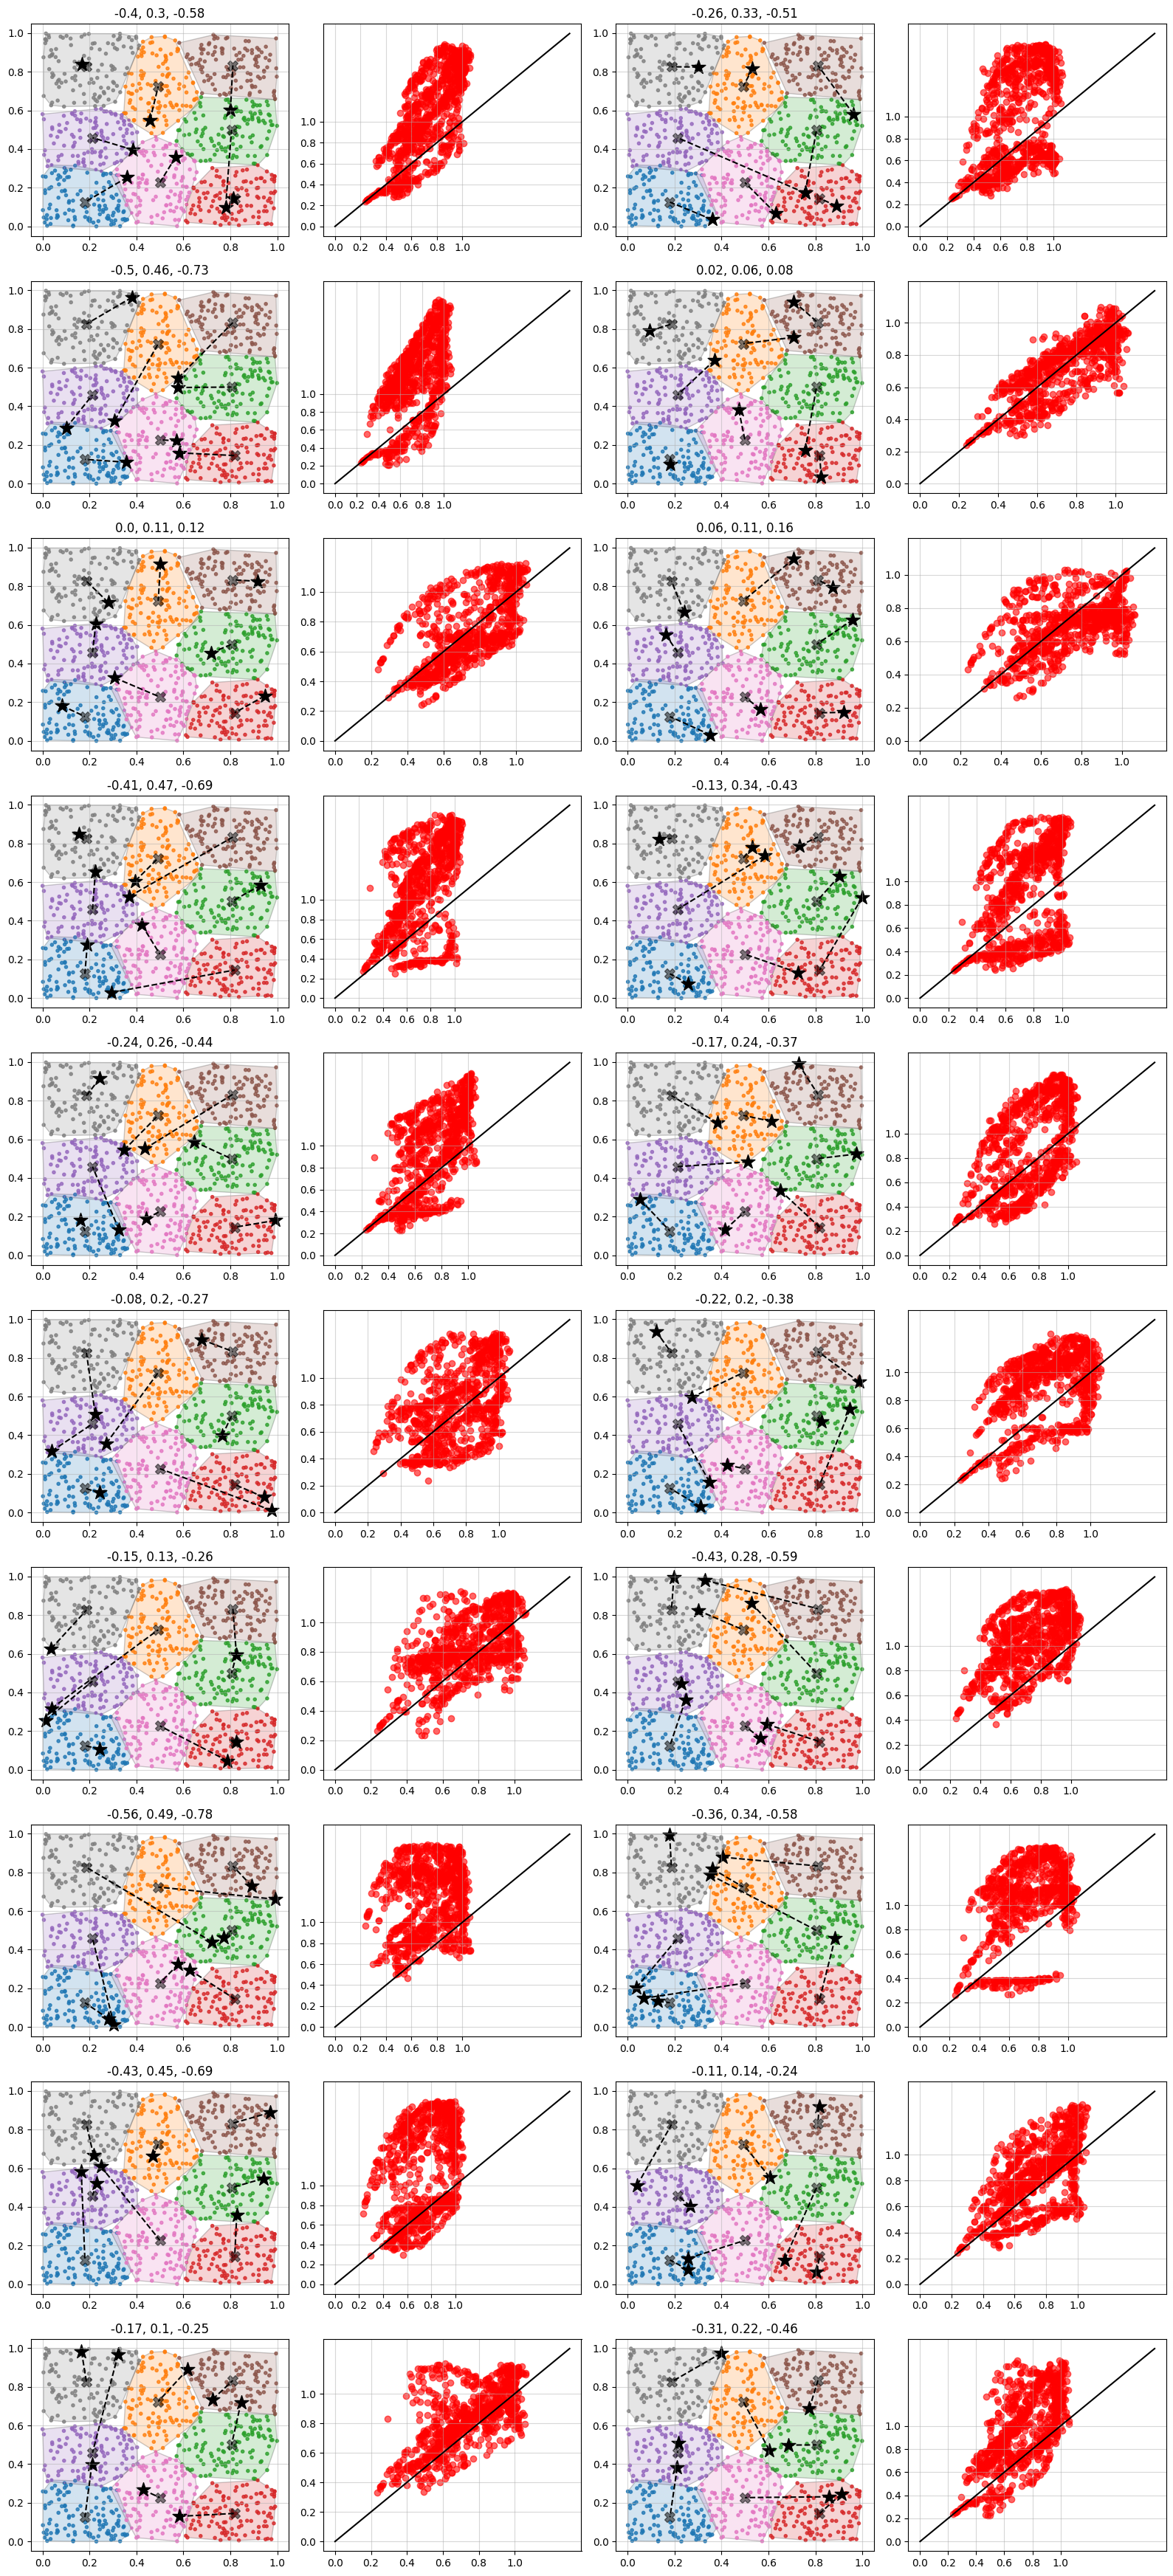

In [78]:
grand_plot2(clusters, centroids, random_samples, random_densities, random_scores)
plt.tight_layout()
plt.savefig("random.png", dpi=150)

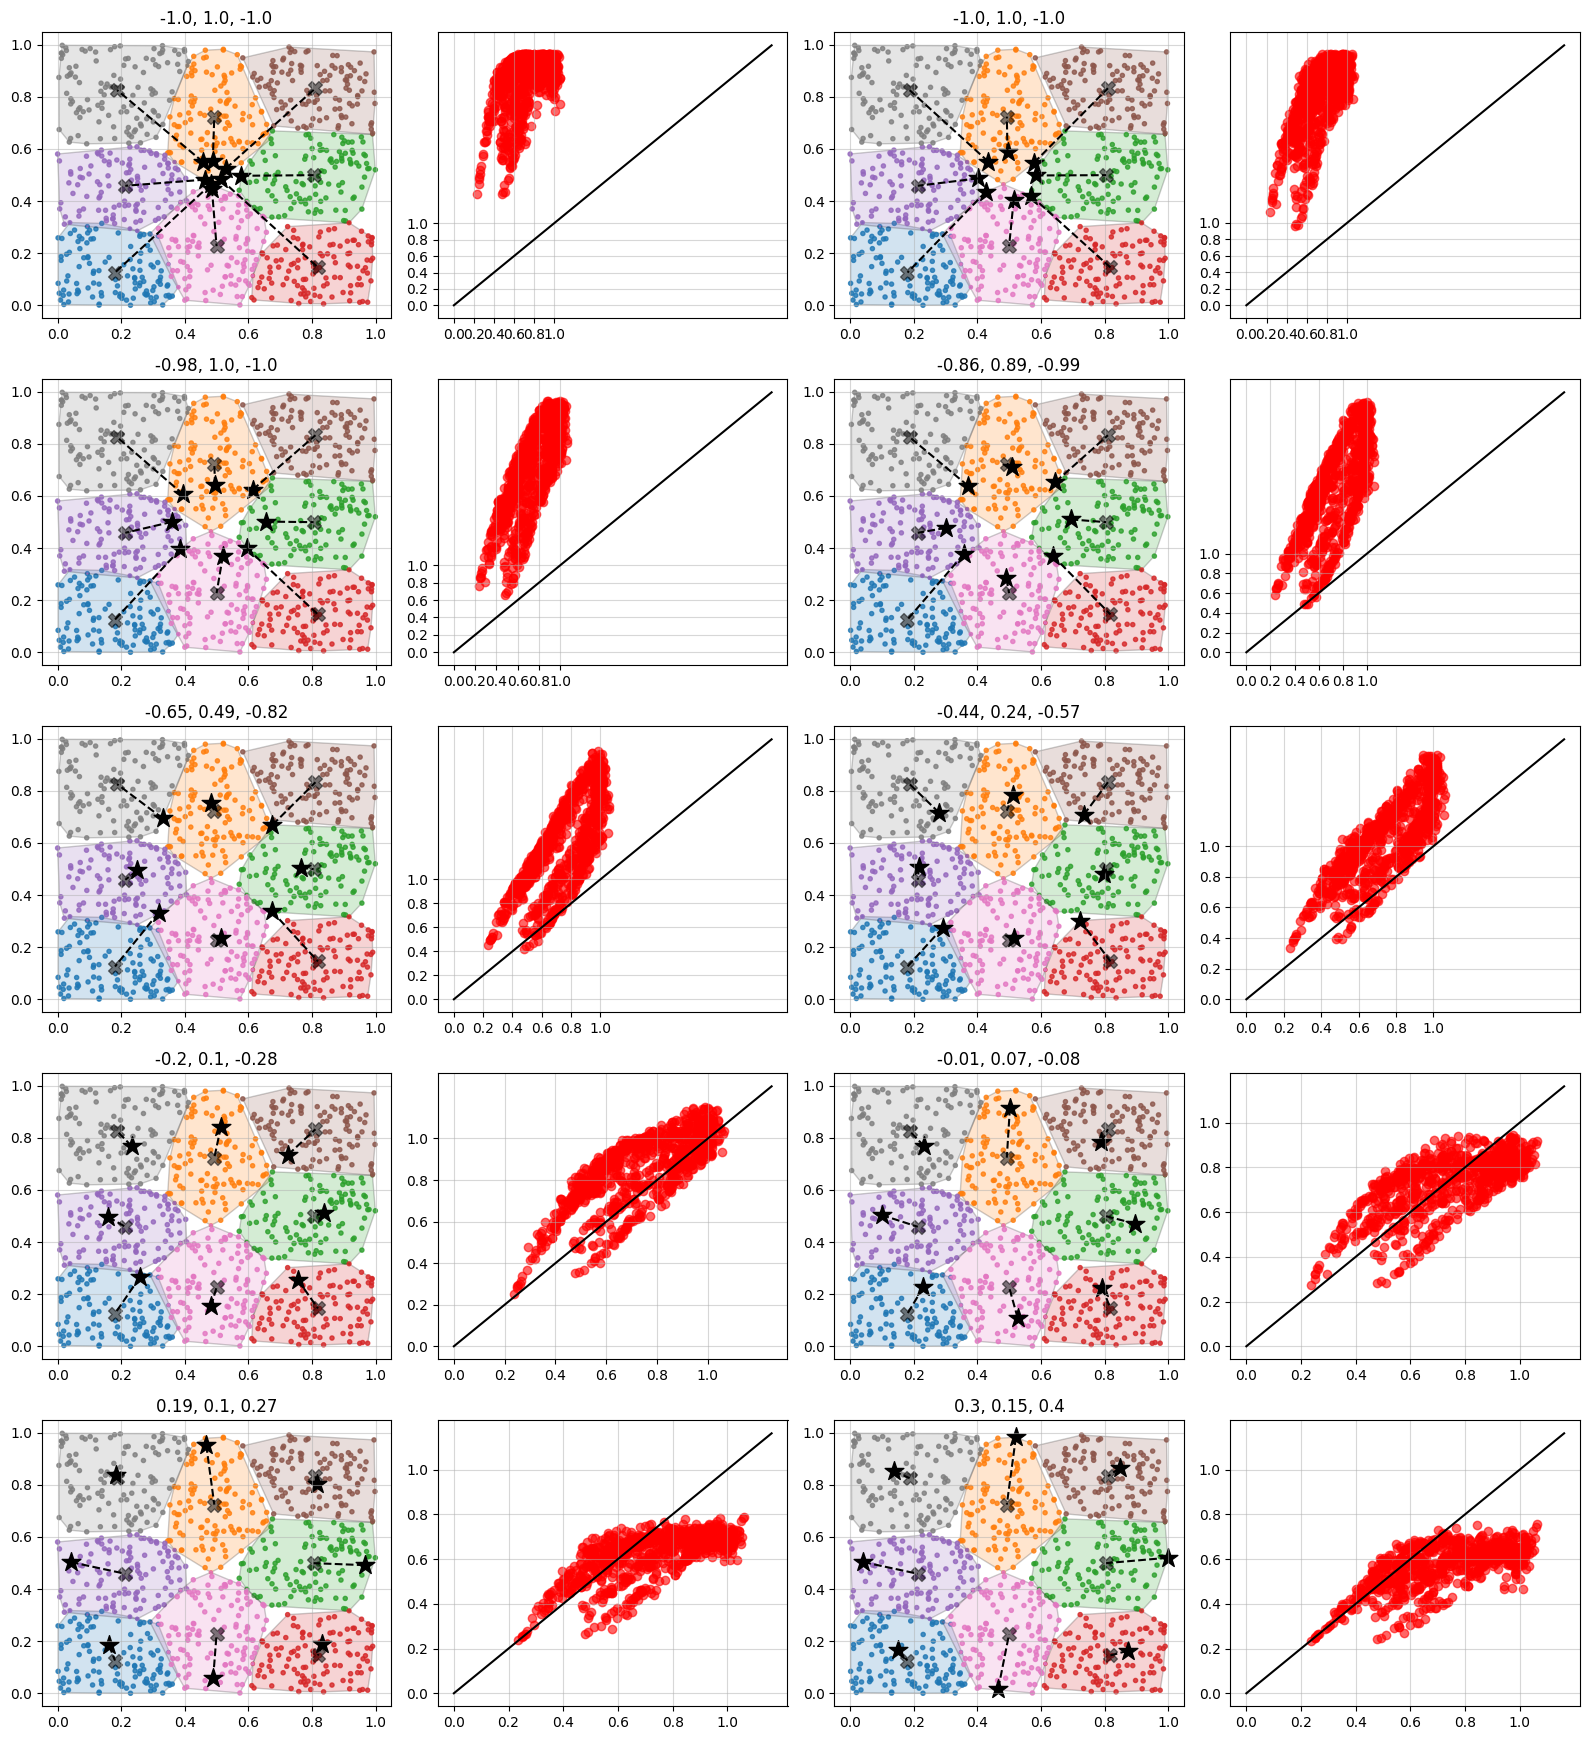

In [79]:
grand_plot2(
    clusters, centroids, handpick_closest_samples, handpick_densities, handpick_scores
)
plt.tight_layout()
plt.savefig("handpick.png", dpi=150)

# Extermum Calculations

In [115]:
def generate_sample_center(grid_size, n_cluster):
    point = two_d_index_to_flat_index(
        (int(np.ceil(grid_size / 2)), int(np.ceil(grid_size / 2)))
    )
    return np.array([point] * n_cluster)


def generate_edge_sample(grid_size):
    points = np.array([[1, 1], [grid_size, 1], [1, grid_size], [grid_size, grid_size]])
    return np.array([two_d_index_to_flat_index(point) for point in points])

In [ ]:
rng = gs.random.rng()

history = {}
mean = {}

for grid_size in range(3, 31):
    coords = rng.grid_coordinates((grid_size, 2))
    probs = rng.unequal_probabilities(n, grid_size**2)
    hist = {}
    m = 0
    i = 0
    for n_cluster in range(4, min(max(5, grid_size + 1), 9)):
        print(grid_size, n_cluster)
        sample = generate_sample_center(grid_size, n_cluster).reshape(1, -1)
        density_measure = gs.measure.Density(coords, probs, n_cluster)
        score, _ = density_measure.score(sample)
        hist[(grid_size, n_cluster)] = score[0][0]
        m += score[0][0]
        i += 1
    mean[grid_size] = m / i
    history[grid_size] = hist

3 4
4 4
5 4
5 5
6 4
6 5
6 6
7 4
7 5
7 6
7 7
8 4
8 5
8 6
8 7
8 8
9 4
9 5
9 6
9 7
9 8
10 4
10 5
10 6
10 7
10 8
11 4
11 5
11 6
11 7
11 8
12 4
12 5
12 6
12 7
12 8
13 4
13 5
13 6
13 7
13 8
14 4
14 5
14 6
14 7
14 8
15 4
15 5
15 6
15 7
15 8
16 4
16 5
16 6
16 7
16 8
17 4
17 5
17 6
17 7
17 8
18 4
18 5
18 6
18 7
18 8
19 4
19 5
19 6
19 7
19 8
20 4
20 5
20 6
20 7
20 8
21 4
21 5
21 6
21 7
21 8
22 4
22 5
22 6
22 7
22 8
23 4
23 5
23 6
23 7
23 8
24 4
24 5
24 6
24 7
24 8
25 4
25 5
25 6
25 7
25 8
26 4
26 5
26 6
26 7
26 8
27 4
27 5
27 6
27 7
27 8
28 4
28 5
28 6
28 7
28 8
29 4
29 5
29 6
29 7
29 8
30 4
30 5
30 6
30 7
30 8


In [ ]:
rng = gs.random.rng()

history2 = {}
mean2 = {}

for grid_size in range(31, 51):
    coords = rng.grid_coordinates((grid_size, 2))
    probs = rng.unequal_probabilities(n, grid_size**2)
    hist = {}
    m = 0
    i = 0
    for n_cluster in range(4, min(max(5, grid_size + 1), 9)):
        print(grid_size, n_cluster)
        sample = generate_sample_center(grid_size, n_cluster).reshape(1, -1)
        density_measure = gs.measure.Density(coords, probs, n_cluster)
        score, _ = density_measure.score(sample)
        hist[(grid_size, n_cluster)] = score[0][0]
        m += score[0][0]
        i += 1
    mean2[grid_size] = m / i
    history2[grid_size] = hist

31 4
31 5
31 6
31 7
31 8
32 4
32 5
32 6
32 7
32 8
33 4
33 5
33 6
33 7
33 8
34 4
34 5
34 6
34 7
34 8
35 4
35 5
35 6
35 7
35 8
36 4
36 5
36 6
36 7
36 8
37 4
37 5
37 6
37 7
37 8
38 4
38 5
38 6
38 7
38 8
39 4
39 5
39 6
39 7
39 8
40 4
40 5
40 6
40 7
40 8
41 4
41 5
41 6
41 7
41 8
42 4
42 5
42 6
42 7
42 8
43 4
43 5
43 6
43 7
43 8
44 4
44 5
44 6
44 7
44 8
45 4
45 5
45 6
45 7
45 8
46 4
46 5
46 6
46 7
46 8
47 4
47 5
47 6
47 7
47 8
48 4
48 5
48 6
48 7
48 8
49 4
49 5
49 6
49 7
49 8
50 4
50 5
50 6
50 7
50 8


In [148]:
mean_for_plot = []
for grid_size, measure in mean.items():
    mean_for_plot.append([grid_size, measure])

for grid_size, measure in mean2.items():
    mean_for_plot.append([grid_size, measure])

mean_for_plot = np.array(mean_for_plot)

In [145]:
line4 = []
line5 = []
line6 = []
line7 = []
line8 = []
for grid_size, hist in history.items():
    for key, measure in hist.items():
        if key[1] == 4:
            line4.append([grid_size, measure])
        elif key[1] == 5:
            line5.append([grid_size, measure])
        elif key[1] == 6:
            line6.append([grid_size, measure])
        elif key[1] == 7:
            line7.append([grid_size, measure])
        elif key[1] == 8:
            line8.append([grid_size, measure])

for grid_size, hist in history2.items():
    for key, measure in hist.items():
        if key[1] == 4:
            line4.append([grid_size, measure])
        elif key[1] == 5:
            line5.append([grid_size, measure])
        elif key[1] == 6:
            line6.append([grid_size, measure])
        elif key[1] == 7:
            line7.append([grid_size, measure])
        elif key[1] == 8:
            line8.append([grid_size, measure])

line4 = np.array(line4)
line5 = np.array(line5)
line6 = np.array(line6)
line7 = np.array(line7)
line8 = np.array(line8)

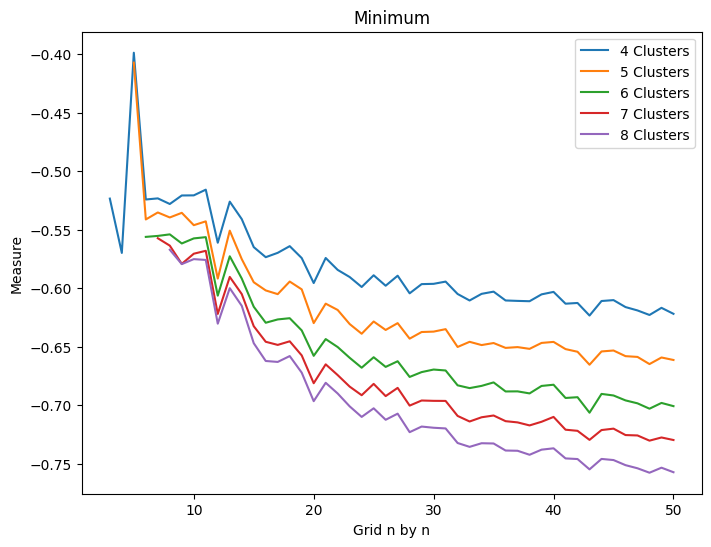

In [160]:
plt.figure(figsize=(8, 6))

plt.plot(*line4.T, label="4 Clusters")
plt.plot(*line5.T, label="5 Clusters")
plt.plot(*line6.T, label="6 Clusters")
plt.plot(*line7.T, label="7 Clusters")
plt.plot(*line8.T, label="8 Clusters")

plt.xlabel("Grid n by n")
plt.ylabel("Measure")
plt.legend()

plt.title("Minimum")

plt.savefig("minimum.png", dpi=300)

In [ ]:
rng = gs.random.rng()

history_max = {}

for grid_size in range(3, 51):
    coords = rng.grid_coordinates((grid_size, 2))
    probs = rng.unequal_probabilities(4, grid_size**2)
    sample = generate_edge_sample(grid_size).reshape(1, -1)
    density_measure = gs.measure.Density(coords, probs, 4)
    score, _ = density_measure.score(sample)
    history_max[grid_size] = score[0][0]
    print(grid_size)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [158]:
history_max

{3: np.float64(0.31384223217153756),
 4: np.float64(0.2862706910132282),
 5: np.float64(0.4166105260006285),
 6: np.float64(0.30742375646788317),
 7: np.float64(0.33234181608234925),
 8: np.float64(0.3254455111504969),
 9: np.float64(0.3089272558776664),
 10: np.float64(0.3270003388280634),
 11: np.float64(0.3196565611149643),
 12: np.float64(0.2817887428589008),
 13: np.float64(0.3056926508749042),
 14: np.float64(0.2916376482805438),
 15: np.float64(0.27378223740843066),
 16: np.float64(0.26364887086002153),
 17: np.float64(0.2640022518277183),
 18: np.float64(0.26163103204953114),
 19: np.float64(0.25413491816099615),
 20: np.float64(0.2399402290941454),
 21: np.float64(0.2502175437155209),
 22: np.float64(0.24131833590708768),
 23: np.float64(0.23598913952784448),
 24: np.float64(0.22998102297188627),
 25: np.float64(0.23265982426367546),
 26: np.float64(0.22723146598228178),
 27: np.float64(0.22828551568464095),
 28: np.float64(0.21996854980423397),
 29: np.float64(0.2211163671327

In [159]:
max_line = []
for grid_size, measure in history_max.items():
    max_line.append([grid_size, measure])

max_line = np.array(max_line)

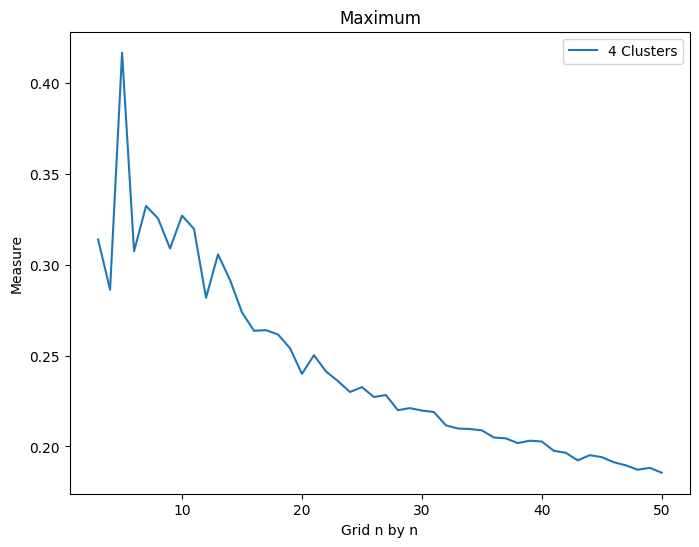

In [161]:
plt.figure(figsize=(8, 6))

plt.plot(*max_line.T, label="4 Clusters")

plt.xlabel("Grid n by n")
plt.ylabel("Measure")
plt.legend()

plt.title("Maximum")

plt.savefig("maximum.png", dpi=300)